In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import mlab 
import numpy as np

%matplotlib inline

# Load dataset

In [2]:
# Util functions to load a UCR dataset
def load(csv_path):
    df = pd.read_csv(csv_path)
    df.columns = ['label'] + ['t%s' % i for i in range(len(df.columns) - 1)]
    return df

In [3]:
df = load('UCR_TS_Archive_2015/Phoneme/Phoneme_TEST')
print 'timeserie length:', len(df.columns)
print 'nb timeseries:', len(df)
print 'columns:', df.columns.values
print 'labels:', df.label.unique()

good_labels = []
for l in df.label.unique():
    c = len(df[df.label ==l])
    if c > 100:
        good_labels.append(l)
print 'good_labels:', good_labels

timeserie length: 1025
nb timeseries: 1895
columns: ['label' 't0' 't1' ..., 't1021' 't1022' 't1023']
labels: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 26 27 28 29 30 31 32 33 34 35 36 37 38 39]
good_labels: [3, 21, 23, 28, 29, 31]


# Plot phonemes

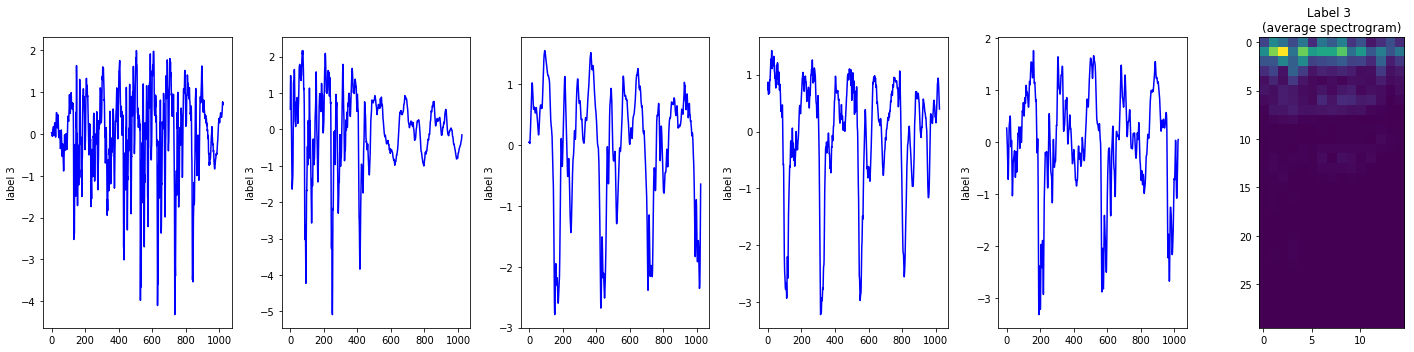

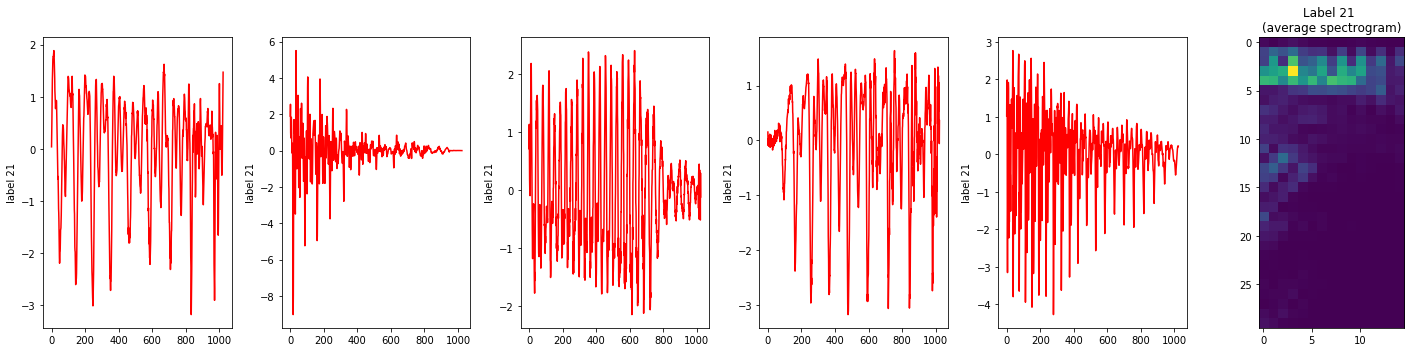

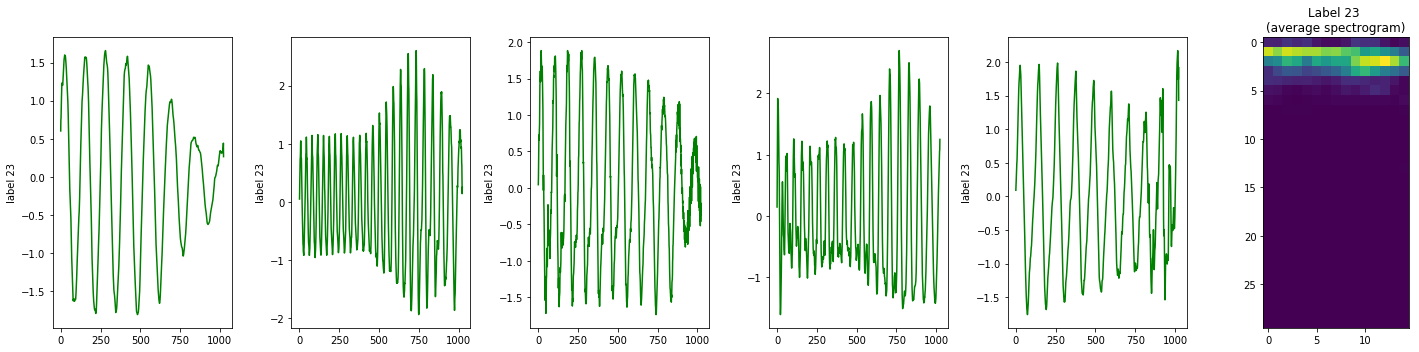

In [130]:
nb_samples = 5
nb_labels = 3
start_label = 0
max_freq = 30
labels = good_labels[start_label:start_label+nb_labels]

colors = ['b', 'r', 'g']
for k in range(nb_labels):
    l = labels[k]
    c = colors[k]
    plt.figure(figsize=(20,5))

    freqs_list = []
    for i in range(nb_samples):
        data = df[df.label==l].iloc[i,1:].values
        
        freqs, m2, m3 = mlab.specgram(data, NFFT=128, noverlap=64)
        freqs_list.append(freqs.tolist())
        
        plt.subplot(1,nb_samples+1,i+1)
        plt.plot(data, color=c)
        plt.ylabel('label %s' % l)
        
    mean_freqs = np.mean(np.array(freqs_list), axis=0)
    assert freqs.shape == mean_freqs.shape
    plt.subplot(1,nb_samples+1,nb_samples+1)
    plt.imshow(mean_freqs[:max_freq,:], interpolation='nearest')
    plt.title('Label %s \n(average spectrogram)' % l)
    
    plt.tight_layout()

# Pick one phoneme

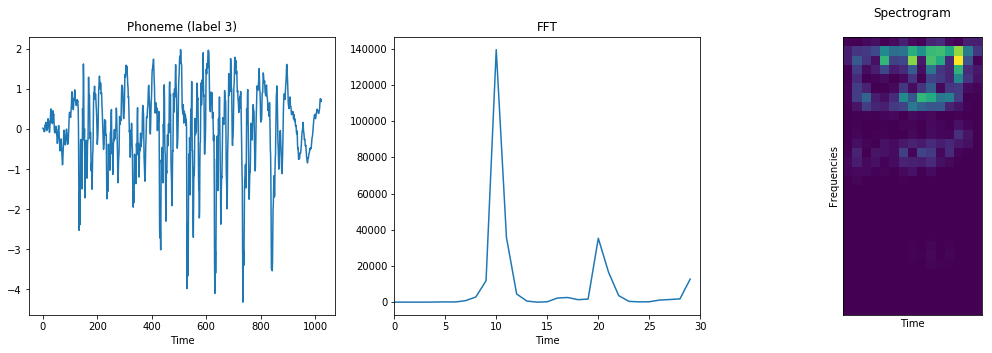

In [154]:
max_freq = 30
label = good_labels[0]
ts_idx = 0
data = df[df.label==label].iloc[ts_idx,1:].values
freqs, m2, m3 = mlab.specgram(data, NFFT=128, noverlap=64, Fs=22050)
freqs = freqs[:max_freq, :]

plt.figure(figsize=(15,5))
ax1 = plt.subplot(131)
ax1.plot(data)
ax1.set_title('Phoneme (label %s)' %label)
ax1.set_xlabel('Time')

fftData=abs(np.fft.rfft(data))**2
fftData = fftData[:max_freq]

ax2 = plt.subplot(132)
ax2.plot(fftData)
ax2.set_xlim(0, max_freq)
ax2.set_xlabel('Time')
ax2.set_title('FFT')

ax3 = plt.subplot(133)
ax3.matshow(freqs)
ax3.set_xticks([])
ax3.set_yticks([])
ax3.set_xlabel('Time')
ax3.set_ylabel('Frequencies')
ax3.set_title('Spectrogram')

plt.tight_layout()

# Check FFT with simple sine wave

1.99974825535 9815.29431046


(0, 30)

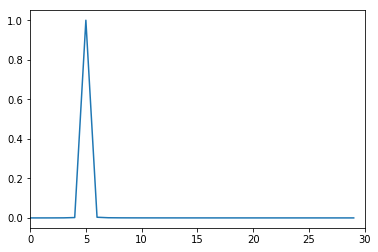

In [71]:
# Sine wave

f = 5
x = np.linspace(0,100, 100)
data = 2. * np.sin(x*2*np.pi * f)

fftData=abs(np.fft.rfft(data))**2

print np.max(data), np.max(fftData)
fftData = fftData[:max_freq] / np.max(fftData)

plt.figure()
plt.plot(fftData)
plt.xlim(0, max_freq)

In [156]:
from frequency_encoder import FrequencyEncoder, pprint
frequencyCutoff = 30
numFrequencyBins = 16
freqBinN = 16
freqBinW = 1
minval = 0.0
maxval = 1.0 # 2600
normalize = True

encoder = FrequencyEncoder(frequencyCutoff, numFrequencyBins, freqBinN,
                           freqBinW, minval, maxval, normalize=normalize)



def plot_encoding(inputData, encoding, title):
    plt.figure(figsize=(15,4))
    ax1 = plt.subplot(131)
    ax1.plot(inputData)
    ax1.set_title(title)
    
    fftData=abs(np.fft.rfft(inputData))**2
    if normalize and np.max(fftData) > 0:fftData /= np.max(fftData)
    ax2 = plt.subplot(132)
    ax2.plot(fftData)
    w = (maxval-minval)/freqBinN * freqBinW
    for i in range(freqBinN/freqBinW - 1):
        ax2.axhline((i+1)*w, c='grey', ls='-.')

    w = len(fftData) / numFrequencyBins
    for k in range(numFrequencyBins -1):
        ax2.axvline((k+1)*w, c='grey', ls='-.')

    ax2.set_xlim(0, len(fftData))
    ax2.set_ylim(0, maxval)
    ax2.set_title('FFT')
    
    ax3 = plt.subplot(133)
    ax3.imshow(np.flipud(encoding.reshape((numFrequencyBins, freqBinN)).T), cmap='Greys')
    ax3.set_xticks([])
    ax3.set_yticks([])
    ax3.set_title('Encoding')
    plt.tight_layout()


# Encoding of sine waves

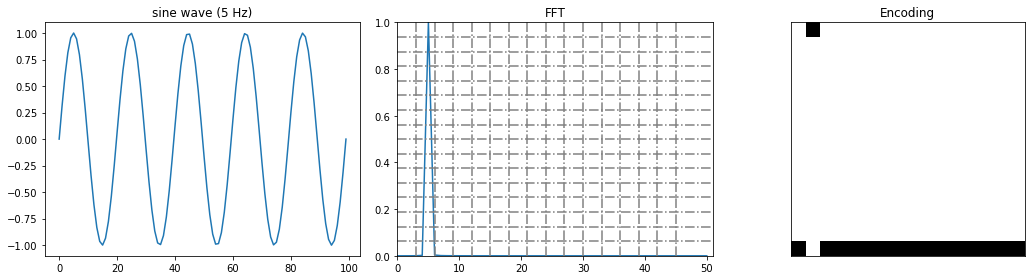

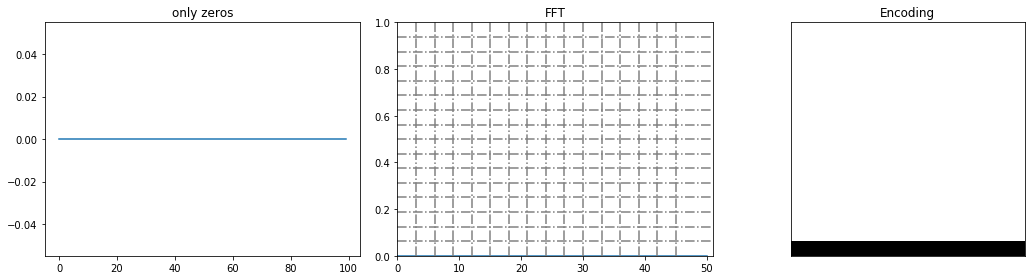

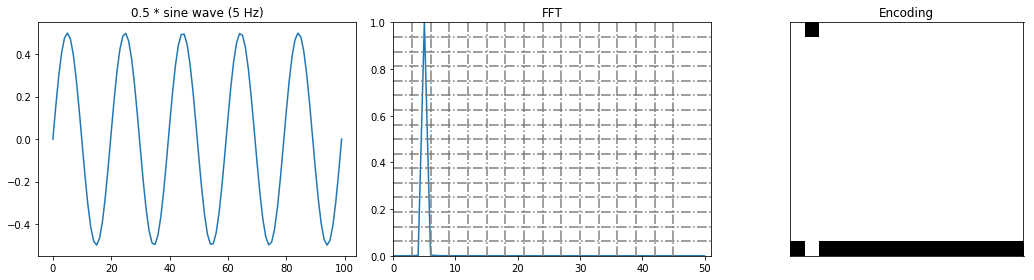

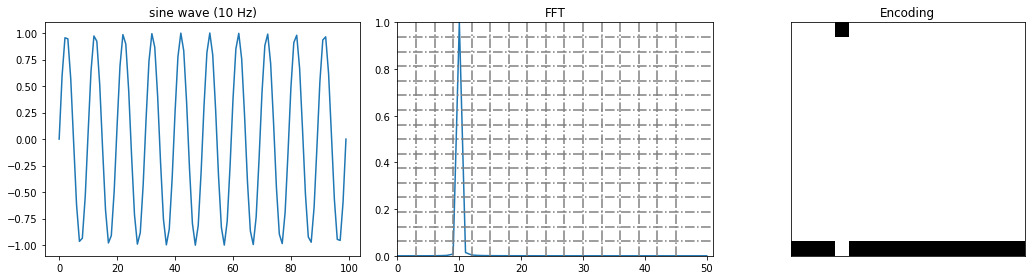

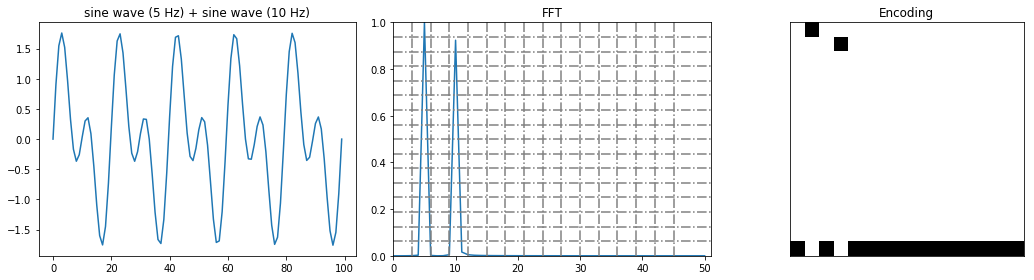

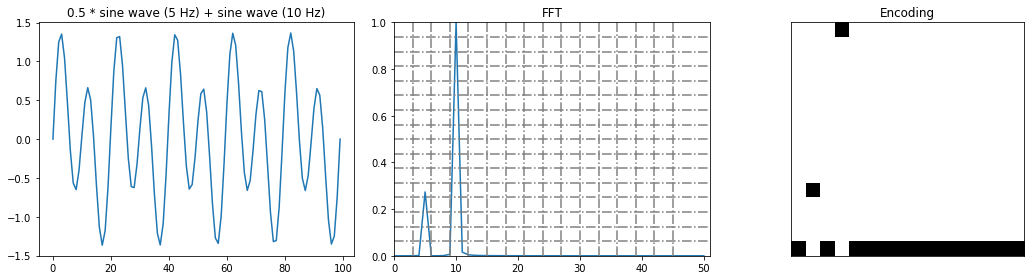

In [157]:
x = np.linspace(0, 100, 100)


title = 'sine wave (5 Hz)'
f = 5
inputData = np.sin(x * 2 * np.pi * f)
encoding = encoder.encode(inputData)
plot_encoding(inputData, encoding, title)

title = 'only zeros'
inputData = np.zeros(len(x))
encoding = encoder.encode(inputData)
plot_encoding(inputData, encoding, title)

title = '0.5 * sine wave (5 Hz)'
f = 5
inputData = 0.5 * np.sin(x * 2 * np.pi * f)
encoding = encoder.encode(inputData)
plot_encoding(inputData, encoding, title)


title = 'sine wave (10 Hz)'
f = 10
inputData = np.sin(x * 2 * np.pi * f)
encoding = encoder.encode(inputData)
plot_encoding(inputData, encoding, title)

title = 'sine wave (5 Hz) + sine wave (10 Hz)'
f = 5
inputData = np.sin(x * 2 * np.pi * f) + np.sin(x * 2 * np.pi * 2 * f)
encoding = encoder.encode(inputData)
plot_encoding(inputData, encoding, title)


title = '0.5 * sine wave (5 Hz) + sine wave (10 Hz)'
f = 5
inputData = 0.5 * np.sin(x * 2 * np.pi * f) + np.sin(x * 2 * np.pi * 2 * f)
encoding = encoder.encode(inputData)
plot_encoding(inputData, encoding, title)



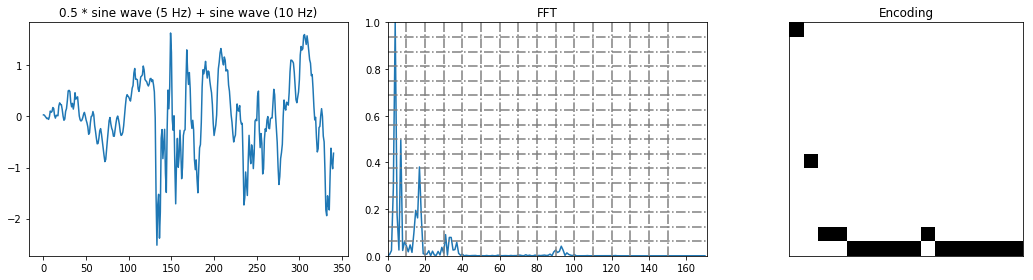

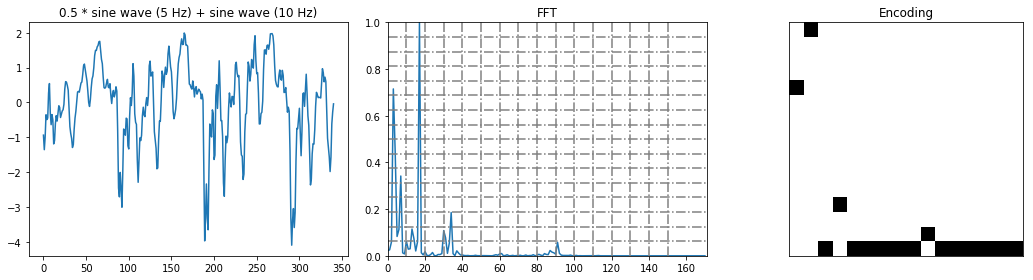

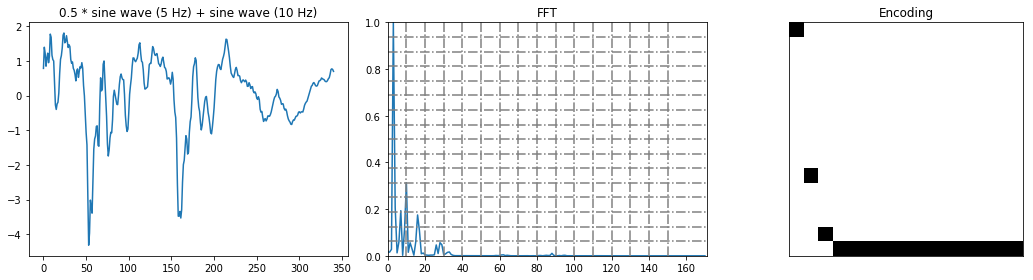

In [158]:
n_chunks = 3
chunk_w = len(data)/ n_chunks

for i in range(n_chunks):
    inputData = data[i*chunk_w:(i+1)*chunk_w]
    encoding = encoder.encode(inputData)
    plot_encoding(inputData, encoding, title)
    